<a href="https://colab.research.google.com/github/JackGraymer/Advanced-GenAI/blob/main/2.1_rag_research_agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Generative Artificial Intelligence
**Project - Designing a RAG-Based Q&A System for News Retrieval**

**Authors:** Vsevolod Mironov, Pascal Küng, Alvaro Cervan (Group 5)


# Step 2.1 - Building the RAG System: Research Agents -<br> Implementing multiple pre-retrieval and retrieval strategies

**Contribution:** Vsevolod Mironov, Pascal Küng, Alvaro Cervan

**Goal of this step:** Implementing and comparing diﬀerent pre-retrieval and retrieval strategies to extract relevant candidate documents. These retrieved documents will go through the post-retrieval process in Step 2.2.

#  1. Data Preprocessing and Benchmark Construction

## 1.1 Setup of the environment

### Installations and loading of packages

Below the necessary libraries are installed and loaded into the environment.

In [32]:
import os
import re
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from langchain.text_splitter import RecursiveCharacterTextSplitter

### Setting seeds and mounting Google Drive storage folder

In [2]:
# Set the seed for consistent results
seed_value = 2138247234
random.seed(seed_value)
np.random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

Below we mount a shared Google Drive folder as a data storage and define the base path of the folder that will be used in the runtime.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
base_folder = '/content/drive/MyDrive/AdvGenAI'

### Check properties of environment

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!pip list

Package                               Version
------------------------------------- -------------------
absl-py                               1.4.0
accelerate                            1.6.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.11.15
aiosignal                             1.3.2
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.6
ale-py                                0.11.0
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.9.0
argon2-cffi                           23.1.0
argon2-cffi-bindings                  21.2.0
array_record                          0.7.2
arviz                                 0.21.0
astropy                               7.0.2
astropy-iers-data                     0.2025.5.12.0.38.29
astunparse                            1

## 1.2 Loading the dataset from stage 1

In [12]:
df = pd.read_csv(os.path.join(base_folder, 'Stage1/Final-Datasets/Stage1-final.csv'))

In [13]:
df.head()

,folder_path,file_name,year,month,language,type,title,content,named_entities,topics,keywords,summary
0,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,"Als 1950 die Meteorologen Jule Charney, Ragnar...","[('CO2', 'MISC'), ('Klimamodelle\n\n', 'PER'),...","['klimamodelle', 'prozesse', 'modelle', 'gitte...","['wetterprognose', 'wettermodellen', 'precipit...","Geht es aber darum, wie häufig heisse und glei..."
1,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,scientifica-teaser-kerosin-aus-luft.html,2019,8,de,news events,Scientifica teaser kerosin aus luft,"Vieles, womit sich Wissenschaftlerinnen und Wi...","[('Schweiz', 'LOC'), ('Scientifica', 'LOC'), (...","['science', 'scientifica', 'wissenschaftlerinn...","['wissenschaftsfestival', 'wissenschaftlerinne...","Vieles, womit sich Wissenschaftlerinnen und Wi..."
2,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,kraftwerk-vor-dem-fenster.html,2019,8,de,news events,Kraftwerk vor dem fenster,Gebäude zu heizen oder zu kühlen benötigt Ener...,"[('Komfort', 'LOC'), ('Nature Energy 4', 'MISC...","['fassade', 'energie', 'gebäude', 'raum', 'pro...","['energiesparpotenzial', 'gebäudesysteme', 'so...",Die Wirkung der adaptiven Solarfassade wird Sc...
3,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,eth-plus-initiativen.html,2019,8,de,news events,Eth plus initiativen,"Das Interesse an ETH+, in dessen Rahmen bereit...","[('Zentrum', 'ORG'), ('ETH', 'ORG'), ('ETH Zür...","['eth', 'professur', 'zusammenarbeit', 'bereic...","['ausgezeichneten', 'eth', 'elektronengetriebe...","Das Interesse an ETH+, in dessen Rahmen bereit..."
4,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,kuenstliche-intelligenz-im-podcast.html,2019,8,de,news events,Kuenstliche intelligenz im podcast,Künstliche Intelligenz und maschinelles Lernen...,"[('Benjamin Grewe', 'PER'), ('ETH Zürich', 'OR...","['intelligenz', 'sprechen', 'science', 'maschi...","['technologien', 'künstlichen', 'künstliche', ...",Im Podcast sprechen wir mit den ETH-Professore...


Below we plot the dataframe sorted by the length of the `content` column. We will remove the rows where the content is less than 45 characters, since those texts don't provide any useful information.

In [14]:
print(df.shape)

(4351, 12)


In [15]:
# sort df by lenght of context ascending
df.sort_values(by='content', key=lambda x: x.str.len(), ascending=True).head(10)

,folder_path,file_name,year,month,language,type,title,content,named_entities,topics,keywords,summary
1143,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,medienmitteilung-stop-hate-speech-alliance-f-u...,2023,2,de,news events,Medienmitteilung stop hate speech alliance f u...,## Kontakt,[],['kontakt'],['kontakt'],## Kontakt
4081,/content/drive/MyDrive/AdvGenAI/data/en_news_e...,medienmitteilung-stop-hate-speech-alliance-f-u...,2023,2,en,news events,Medienmitteilung stop hate speech alliance f u...,## Contact,"[('## Contact', 'MONEY')]",['contact'],['contact'],## Contact
1705,/content/drive/MyDrive/AdvGenAI/data/de_intern...,mendeley-literaturverwaltung.html,2014,1,de,internal,Mendeley literaturverwaltung,Weitere Informationen\n\n,[],['informationen'],"['weitere', 'informationen']",Weitere Informationen
1749,/content/drive/MyDrive/AdvGenAI/data/de_intern...,citavi-literaturverwaltung.html,2014,2,de,internal,Citavi literaturverwaltung,Weitere Informationen\n\n,[],['informationen'],"['weitere', 'informationen']",Weitere Informationen
1704,/content/drive/MyDrive/AdvGenAI/data/de_intern...,web-of-science-alles-neu-macht-der--januar-.html,2014,1,de,internal,Web of science alles neu macht der januar,Weitere Informationen\n\n,[],['informationen'],"['weitere', 'informationen']",Weitere Informationen
2262,/content/drive/MyDrive/AdvGenAI/data/de_intern...,usa-fulbright-specialist-program.html,2024,6,de,internal,Usa fulbright specialist program,Siehe Details auf der englischen Webseite.,"[('englischen', 'MISC')]","['details', 'englischen', 'siehe', 'webseite']","['webseite', 'englischen', 'siehe', 'auf', 'der']",Siehe Details auf der englischen Webseite.
2217,/content/drive/MyDrive/AdvGenAI/data/de_intern...,usa-fulbright-specialist-program.html,2024,1,de,internal,Usa fulbright specialist program,Siehe Details auf der englischen Webseite.,"[('englischen', 'MISC')]","['details', 'englischen', 'webseite', 'siehe']","['webseite', 'englischen', 'siehe', 'auf', 'der']",Siehe Details auf der englischen Webseite.
2549,/content/drive/MyDrive/AdvGenAI/data/en_intern...,had-enough-of-long-training-courses.html,2014,10,en,internal,Had enough of long training courses,The events take place from 12.15 to 12.30:\n\n,"[('12.30', 'CARDINAL'), ('12.15', 'CARDINAL')]","['events', 'place']","['events', '12', '15', '30', 'place']",The events take place from 12.15 to 12.30:
1740,/content/drive/MyDrive/AdvGenAI/data/de_intern...,tablets-fuer-studium-und-arbeit--betriebssyste...,2014,4,de,internal,Tablets fuer studium und arbeit betriebssystem...,Themen:\n\nWeitere Informationen und Anmeldung...,[],"['anmeldung', 'informationen', 'themen']","['informationen', 'weitere', 'anmeldung', 'the...",Themen: Weitere Informationen und Anmeldung
1399,/content/drive/MyDrive/AdvGenAI/data/de_intern...,together-2018.html,2018,9,de,internal,Together 2018,## Impressionen\n\nBilder: ETH Zürich / Alessa...,"[('Alessandro Della Bella\n\n', 'PER'), ('ETH ...","['alessandro', 'bella', 'bilder', 'della', 'et...","['zürich', 'impressionen', 'alessandro', 'dell...",## Impressionen Bilder: ETH Zürich / Alessandr...


In [16]:
df = df[df['content'].str.len() > 45]
print(df.shape)

(4343, 12)


For easier handling in the following steps we add an ID for each row starting at "0000" (including leading zeros).

In [17]:
df = df.reset_index(drop=True)
df.insert(0, 'text_id', df.index.astype(str).str.zfill(4))

In [18]:
df.head()

,text_id,folder_path,file_name,year,month,language,type,title,content,named_entities,topics,keywords,summary
0,0000,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,"Als 1950 die Meteorologen Jule Charney, Ragnar...","[('CO2', 'MISC'), ('Klimamodelle\n\n', 'PER'),...","['klimamodelle', 'prozesse', 'modelle', 'gitte...","['wetterprognose', 'wettermodellen', 'precipit...","Geht es aber darum, wie häufig heisse und glei..."
1,0001,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,scientifica-teaser-kerosin-aus-luft.html,2019,8,de,news events,Scientifica teaser kerosin aus luft,"Vieles, womit sich Wissenschaftlerinnen und Wi...","[('Schweiz', 'LOC'), ('Scientifica', 'LOC'), (...","['science', 'scientifica', 'wissenschaftlerinn...","['wissenschaftsfestival', 'wissenschaftlerinne...","Vieles, womit sich Wissenschaftlerinnen und Wi..."
2,0002,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,kraftwerk-vor-dem-fenster.html,2019,8,de,news events,Kraftwerk vor dem fenster,Gebäude zu heizen oder zu kühlen benötigt Ener...,"[('Komfort', 'LOC'), ('Nature Energy 4', 'MISC...","['fassade', 'energie', 'gebäude', 'raum', 'pro...","['energiesparpotenzial', 'gebäudesysteme', 'so...",Die Wirkung der adaptiven Solarfassade wird Sc...
3,0003,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,eth-plus-initiativen.html,2019,8,de,news events,Eth plus initiativen,"Das Interesse an ETH+, in dessen Rahmen bereit...","[('Zentrum', 'ORG'), ('ETH', 'ORG'), ('ETH Zür...","['eth', 'professur', 'zusammenarbeit', 'bereic...","['ausgezeichneten', 'eth', 'elektronengetriebe...","Das Interesse an ETH+, in dessen Rahmen bereit..."
4,0004,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,kuenstliche-intelligenz-im-podcast.html,2019,8,de,news events,Kuenstliche intelligenz im podcast,Künstliche Intelligenz und maschinelles Lernen...,"[('Benjamin Grewe', 'PER'), ('ETH Zürich', 'OR...","['intelligenz', 'sprechen', 'science', 'maschi...","['technologien', 'künstlichen', 'künstliche', ...",Im Podcast sprechen wir mit den ETH-Professore...


In [19]:
# safe dataset
df.to_csv(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-01-loaded-dataset.csv'), index=False)

## 1.3 Chunking of the news texts

In [45]:
# Load dataset
df = pd.read_csv(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-01-loaded-dataset.csv'))

In this section we chunk our contents into smaller chunks. There are many different chunking methods. Since the text are in a markdown structure we will define a chunker that utilizes the properties of the markdown format by splitting the documents before the section headers.

After this splitting not all parts have a reasonable length. Therefore we first merge chunks that are too small with the proceeding chunk. After that we go through the chunks and split those that are too large using a `RecursiveCharacterTextSplitter` with a defined chunk overlap.

The minimal length of a chunk should be set so is long enough to contain information and meaning. For the maximum length we look back at previous projects. For example in CLT we built upon an existing RAG pipeline by Daniel Perruchoud and George Rowlands ([Github](https://github.com/LuciferUchiha/Cleantech-RAG/tree/main)). There a maximum length of 1024 characters showed good results.

Since the chunks will be used for embeddings it makes sense to look at the model cards and especially the Intended uses and the training we can discover that many sentence embedding models were trained with a context length of 256 tokens, even though some allow an input of 512 or more tokens when using the models. Others will simply trunctuate at 256 tokens. With an average length of 4 characters per token we get 1024 characters, therefore in general allowing the use of the whole context of the chunk for the embedding.

After trying different settings we decide on a min. chunk size of 150 characters, max. chunk size of 1000 characters and a chunk overlap of 200 characters (if recursive splitting is necessary).

In [46]:
class HierarchicalRecursiveTextSplitter:
    def __init__(self, min_chunk_size=150, max_chunk_size=1000, chunk_overlap=200):
        self.min_chunk_size = min_chunk_size
        self.max_chunk_size = max_chunk_size
        self.chunk_overlap = chunk_overlap
        self.recursive_splitter = RecursiveCharacterTextSplitter(
            separators=["\n\n", "\n", ".", "!", "?", ",", " ", ""],
            chunk_size=max_chunk_size,
            chunk_overlap=chunk_overlap,
        )

    def split_by_header(self, text: str) -> List[str]:
        # Use multiline matching to split on header lines starting with '## '
        pattern = re.compile(r'(^## .+$)', flags=re.MULTILINE)
        splits = pattern.split(text)

        chunks = []
        if splits[0].strip():
            chunks.append(splits[0].strip())
        # Now iterate in step 2: header at i, content i+1
        for i in range(1, len(splits), 2):
            header = splits[i].strip()
            content = splits[i + 1].strip() if (i + 1) < len(splits) else ""
            chunk_text = f"{header}\n{content}"
            chunks.append(chunk_text)

        #replace double newlines with newline
        for i in range(len(chunks)):
            chunks[i] = chunks[i].replace("\n\n", "\n")
            chunks[i] = chunks[i].replace("\n \n", "\n")
            if chunks[i].endswith("\n"):
                chunks[i] = chunks[i][:-2]
        return chunks

    def merge_small_chunks(self, chunks: List[str]) -> List[str]:
        merged_chunks = []
        for chunk in chunks:
            if len(chunk) < self.min_chunk_size:
                if merged_chunks:
                    # Append small chunk to previous chunk with a space separator
                    merged_chunks[-1] += "\n" + chunk  # add newline to separate
                else:
                    # No previous chunk, start new one with this small chunk
                    merged_chunks.append(chunk)
            else:
                # Chunk big enough, start a new chunk
                merged_chunks.append(chunk)
        return merged_chunks

    def recursive_split(self, chunks: List[str]) -> List[str]:
        # Use recursive splitter to chunk large pieces
        final_chunks = []
        for chunk in chunks:
            if len(chunk) > self.max_chunk_size:
                # recursively split
                smaller_chunks = self.recursive_splitter.split_text(chunk)
                final_chunks.extend(smaller_chunks)
            else:
                final_chunks.append(chunk)
        return final_chunks

    def split_text(self, text: str) -> List[str]:
        # 1. Split hierarchically by header
        chunks = self.split_by_header(text)
        # 2. Merge too small chunks
        chunks = self.merge_small_chunks(chunks)
        # 3. Recursively split too large chunks
        chunks = self.recursive_split(chunks)
        return chunks

In [47]:
splitter = HierarchicalRecursiveTextSplitter()

for j in range(5):
  print(f"--- Document {j+1} ---")
  chunks = splitter.split_text(df["content"].iloc[j])

  for i, chunk in enumerate(chunks):
      print(f"--- Chunk {i+1} ---")
      print(chunk)
      print()

--- Document 1 ---
--- Chunk 1 ---
Als 1950 die Meteorologen Jule Charney, Ragnar Fjørtoft und der Mathematiker John von Neumann zusammen mit anderen Forschenden erstmals am Computer das Wetter simulierten, brauchten sie 24 Stunden Rechenzeit, um eine Prognose für 24 Stunden Wetter zu erstellen. Die Voraussage war dürftig, die Realität war schon eingetroffen und damit die Voraussage für niemanden brauchbar. Heute ist die Wetterprognose erstaunlich gut, oft bis eine Woche im Voraus und für extreme Ereignisse. Sie ist auf jedem Telefon verfügbar, und alle wissen, wie sie zu interpretieren ist.

--- Chunk 2 ---
## Erstaunliche Entwicklung der Klimamodelle
Auch die eng mit Wettermodellen verwandten Klimamodelle haben eine erstaunliche Entwicklung durchlaufen. Sie simulieren heute die Strömungen in der Atmosphäre und im Ozean, das Meereis, die Biosphäre und das Land, den Kohlenstoffkreislauf und vieles mehr. Klimamodelle berücksichtigen Tausende von Rückkopplungen und Prozesse des Klimas, u

Looking through the chunks on a subset of the data (see hidden output above) the separation of the hirarchie and the splitting up of the longer chunks (with overlapping text) looks satisfactory.

Therefore we decide to apply this chunking method on our whole dataframe.

In [48]:
def create_chunked_dataframe(df, splitter):
    chunked_data = []

    for idx, row in df.iterrows():
        chunks = splitter.split_text(row['content'])

        for chunk_idx, chunk_text in enumerate(chunks):
            chunk_data = {
                'text_id': str(row['text_id']).zfill(4),  # Ensure leading zeros
                'chunk_id': f"{chunk_idx:02d}",
                'unique_chunk_id': f"{str(row['text_id']).zfill(4)}_{chunk_idx:02d}",  # Also fix here
                'chunk_text': chunk_text,
                'chunk_length': len(chunk_text),
                'total_chunks': len(chunks),
                # Copy all other original columns
                **{col: row[col] for col in df.columns if col not in ['content', 'text_id']}
            }
            chunked_data.append(chunk_data)

    return pd.DataFrame(chunked_data)

In [49]:
# Define splitter and chunk the whole dataset
splitter = HierarchicalRecursiveTextSplitter()
chunked_df = create_chunked_dataframe(df, splitter)

In [50]:
# Change column order
column_order = [
    'unique_chunk_id',   # Global unique identifier
    'chunk_text',        # The actual chunk content
    'chunk_length',      # Length of chunk
    'total_chunks',      # How many chunks in this document
    'folder_path',
    'file_name',
    'year',
    'month',
    'language',
    'type',
    'title',
    'text_id',           # Original document ID
    'chunk_id',          # Chunk number within document
]

chunked_df = chunked_df[column_order]

In [51]:
chunked_df.head()

,unique_chunk_id,chunk_text,chunk_length,total_chunks,folder_path,file_name,year,month,language,type,title,text_id,chunk_id
0,0000_00,"Als 1950 die Meteorologen Jule Charney, Ragnar...",563,8,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,0000,00
1,0000_01,## Erstaunliche Entwicklung der Klimamodelle\n...,804,8,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,0000,01
2,0000_02,"«Alle Modelle sind falsch, aber einige sind nü...",881,8,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,0000,02
3,0000_03,"Doch um die Gitterweite verkleinern zu können,...",536,8,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,0000,03
4,0000_04,Bis ein hochaufgelöstes Modell auf einer neuen...,466,8,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,0000,04


Text(0.5, 1.0, 'Distribution of Chunk Lengths')

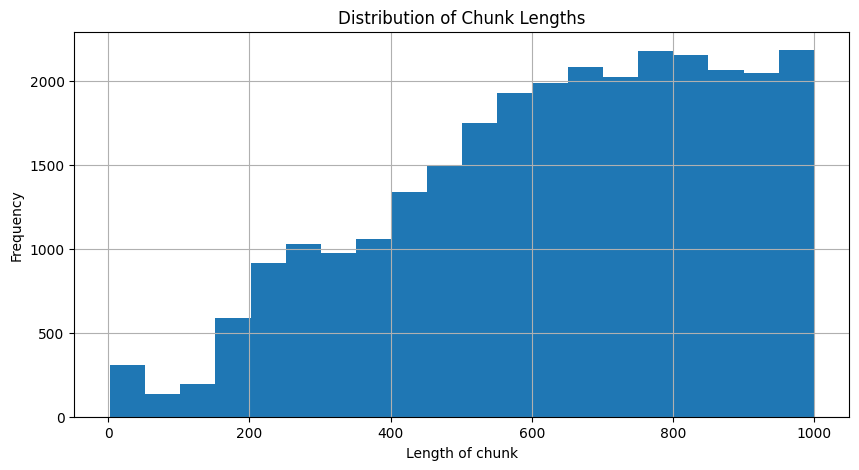

In [55]:
chunked_df['chunk_length'].hist(bins = 20, figsize=(10, 5), grid = True)
plt.xlabel('Length of chunk')
plt.ylabel('Frequency')
plt.title('Distribution of Chunk Lengths')

In [56]:
chunked_df[chunked_df['chunk_length'] < 100]

,unique_chunk_id,chunk_text,chunk_length,total_chunks,folder_path,file_name,year,month,language,type,title,text_id,chunk_id
14,0002_04,## Grösstes Potenzial in gemässigten Zonen,42,10,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,kraftwerk-vor-dem-fenster.html,2019,8,de,news events,Kraftwerk vor dem fenster,0002,04
26,0003_06,## Ingenieurinnen und Ingenieure der Zukunft,44,9,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,eth-plus-initiativen.html,2019,8,de,news events,Eth plus initiativen,0003,06
245,0032_02,## 15 verschiedene Lehrberufe,29,17,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,vocational-education-and-training-at-eth.html,2019,4,de,news events,Vocational education and training at eth,0032,02
319,0040_03,## Über das QS-Ranking nach Fachgebieten,40,6,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,in-13-fachgebieten-in-den-top-ten.html,2019,2,de,news events,In 13 fachgebieten in den top ten,0040,03
604,0080_02,## Vierte Revolution im Agrarbereich,36,17,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,mistgabel-und-drohne.html,2019,9,de,news events,Mistgabel und drohne,0080,02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27910,4273_05,## Further informatio,21,6,/content/drive/MyDrive/AdvGenAI/data/en_news_e...,eth-and-ubs-launch-partnership-to-promote-inno...,2022,8,en,news events,Eth and ubs launch partnership to promote inno...,4273,05
28009,4286_03,## Testing and improving the exomuscle,38,7,/content/drive/MyDrive/AdvGenAI/data/en_news_e...,wearable-muscles.html,2022,6,en,news events,Wearable muscles,4286,03
28033,4289_04,## Award of the title of “Professor of Practice”,48,8,/content/drive/MyDrive/AdvGenAI/data/en_news_e...,four-professors-appointed.html,2022,9,en,news events,Four professors appointed,4289,04
28201,4309_02,## The cosy relationship of power politics and...,58,15,/content/drive/MyDrive/AdvGenAI/data/en_news_e...,blog-war-in-ukraine-back-to-the-19th-century.html,2022,5,en,news events,Blog war in ukraine back to the 19th century,4309,02


In [57]:
chunked_df.head(30)

,unique_chunk_id,chunk_text,chunk_length,total_chunks,folder_path,file_name,year,month,language,type,title,text_id,chunk_id
0,0000_00,"Als 1950 die Meteorologen Jule Charney, Ragnar...",563,8,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,0000,00
1,0000_01,## Erstaunliche Entwicklung der Klimamodelle\n...,804,8,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,0000,01
2,0000_02,"«Alle Modelle sind falsch, aber einige sind nü...",881,8,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,0000,02
3,0000_03,"Doch um die Gitterweite verkleinern zu können,...",536,8,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,0000,03
4,0000_04,Bis ein hochaufgelöstes Modell auf einer neuen...,466,8,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,0000,04
5,0000_05,## Handfester Nutzen für die Gesellschaft\nKli...,806,8,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,0000,05
6,0000_06,## Öffentlicher Vortrag über Klimamodelle\nAm ...,665,8,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,0000,06
7,0000_07,## Referenz\n1 How well have climate models pr...,354,8,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,0000,07
8,0001_00,"Vieles, womit sich Wissenschaftlerinnen und Wi...",836,2,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,scientifica-teaser-kerosin-aus-luft.html,2019,8,de,news events,Scientifica teaser kerosin aus luft,0001,00
9,0001_01,Die Scientifica ist das grösste Wissenschaftsf...,262,2,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,scientifica-teaser-kerosin-aus-luft.html,2019,8,de,news events,Scientifica teaser kerosin aus luft,0001,01
